In [4]:
import pandas as pd
import numpy as np

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [19]:
class Data:
    def __init__(self, path: str) -> None:    
        demand_path = path + "/Demand_history.csv"
        existingEV_path = path + "/existing_EV_infrastructure_2018.csv"
        self.df_orig = pd.read_csv(demand_path)
        self.df_trans = self.df_orig
        self.years_window = 2
        self.y_cols = [f"n-{y}" for y in range(1, self.years_window + 1)]
        
    def clean(self):
        self.df_orig.loc[(self.df_orig != 0).any(1)]
        print(self.df_orig)
        
    def split(self):
        
        x_train = pd.DataFrame(columns=["x_coordinate", "y_coordinate", *self.y_cols])
        x_test = pd.DataFrame(columns=["x_coordinate", "y_coordinate", *self.y_cols])
        y_train = pd.Series(dtype=np.float64)
        y_test = pd.Series(dtype=np.float64)
        for y in self.df_trans.columns[self.df_trans.columns.str.startswith('20')]:
            y = int(y)
            if y < 2010 + self.years_window:
                continue
            y_cols = [f"{y - i}" for i in range(1, self.years_window + 1)]
            stack_x = self.df_trans.loc[:, self.df_trans.columns.isin(["x_coordinate", "y_coordinate", *y_cols])]
            y_dict = {f"{y - i}": f"n-{i}" for i in range(1, self.years_window + 1)}
            stack_x = stack_x.rename(columns=y_dict)
            stack_y = self.df_trans.loc[:, f"{y}"]
            if y == 2018:
                x_test = pd.concat([x_test, stack_x], axis=0, ignore_index=True)
                y_test = pd.concat([y_test, stack_y], axis=0, ignore_index=True)
                x_train = pd.concat([x_train, stack_x], axis=0, ignore_index=True)
                y_train = pd.concat([y_train, stack_y], axis=0, ignore_index=True)
            else:
                x_train = pd.concat([x_train, stack_x], axis=0, ignore_index=True)
                y_train = pd.concat([y_train, stack_y], axis=0, ignore_index=True)
        
        data.x_train = x_train
        data.x_test = x_test
        data.y_train = y_train
        data.y_test = y_test
        
    def addYearDemandfromForecast(self, year: int, predicted: np.array) -> None:
        predicted = predicted.reshape(-1, 1)
        self.df_trans[f"{year}"] = predicted        
                  
path = "data"
data = Data(path)
data.split()

In [20]:
data.x_train

,x_coordinate,y_coordinate,n-1,n-2
0,0.5,0.5,0.667932,0.352242
1,1.5,0.5,0.591964,0.325940
2,2.5,0.5,0.591890,0.373752
3,3.5,0.5,0.584055,0.420686
4,4.5,0.5,0.647940,0.475621
...,...,...,...,...
28667,59.5,63.5,4.149888,3.352280
28668,60.5,63.5,1.309479,1.107797
28669,61.5,63.5,2.333681,1.822806
28670,62.5,63.5,6.096858,4.494515


In [21]:
class Model:
    def __init__(self, data: Data) -> None:
        self.data = data
        self.model = xgb.XGBRegressor()
    
    def feature_importance(self) -> None:
        _ = xgb.plot_importance(self.model, height=0.9)
    
    def fit(self) -> None:
        self.model.fit(data.x_train, data.y_train,
            eval_set=[(data.x_train, data.y_train), (data.x_test, data.y_test)],
            early_stopping_rounds=10)
        
        pred = self.model.predict(data.x_train)
        train_rmse = np.sqrt(mean_squared_error(data.y_train, pred))
        train_mae = mean_absolute_error(data.y_train, pred)   
        train_r2 = r2_score(data.y_train, pred) 
        pred = self.model.predict(data.x_test)
        test_rmse = np.sqrt(mean_squared_error(data.y_test, pred))
        test_mae = mean_absolute_error(data.y_test, pred)   
        test_r2 = r2_score(data.y_test, pred)    
        
        print(f"training: rmse={train_rmse}, mae={train_mae}, r2={train_r2}")   
        print(f"test: rmse={test_rmse}, mae={test_mae}, r2={test_r2}")                        
    
    def predict(self, year: int) -> pd.Series:
        y_cols = [f"{year - i}" for i in range(1, data.years_window + 1)]
        x_forecast = \
            data.df_trans.loc[:,
                              data.df_trans.columns.isin(["x_coordinate", "y_coordinate", *y_cols])]        
        return self.model.predict(x_forecast)
    
    def set_params(self, params):
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        self.model.set_params(**params)
        

In [22]:
model = Model(data)

In [10]:
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 1000, 10),
        'seed': 0,
        'objective': 'reg:squarederror'
    }

def objective(space):
    model.set_params(space)
    
    evaluation = [(data.x_train, data.y_train), (data.x_test, data.y_test)]
    
    model.model.fit(data.x_train, data.y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)
    

    pred = model.model.predict(data.x_test)
    rmse = np.sqrt(mean_squared_error(data.y_test, pred))
    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [12]:
print("The best hyperparameters are : ","\n")
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
print(best_hyperparams)


The best hyperparameters are :  

{'colsample_bytree': 0.5148150925330462, 'gamma': 1.6742600605384315, 'max_depth': 10, 'min_child_weight': 3.0, 'n_estimators': 580, 'reg_alpha': 132.0, 'reg_lambda': 0.3910105859238463}


[0]	validation_0-rmse:52.26205	validation_1-rmse:82.25845
[1]	validation_0-rmse:37.32957	validation_1-rmse:57.01059
[2]	validation_0-rmse:27.10547	validation_1-rmse:39.80341
[3]	validation_0-rmse:20.23763	validation_1-rmse:28.15855
[4]	validation_0-rmse:15.81308	validation_1-rmse:20.47764


/Users/manuel.ramos/miniforge3/envs/py310/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[5]	validation_0-rmse:12.92093	validation_1-rmse:15.63537
[6]	validation_0-rmse:11.56062	validation_1-rmse:14.10434
[7]	validation_0-rmse:10.38224	validation_1-rmse:12.27463
[8]	validation_0-rmse:9.61249	validation_1-rmse:11.34786
[9]	validation_0-rmse:9.19773	validation_1-rmse:10.93139
[10]	validation_0-rmse:8.98022	validation_1-rmse:10.80324
[11]	validation_0-rmse:8.79372	validation_1-rmse:10.80738
[12]	validation_0-rmse:8.63119	validation_1-rmse:10.75038
[13]	validation_0-rmse:8.52896	validation_1-rmse:10.70606
[14]	validation_0-rmse:8.47502	validation_1-rmse:10.72344
[15]	validation_0-rmse:8.34596	validation_1-rmse:10.59890
[16]	validation_0-rmse:8.25034	validation_1-rmse:10.58245
[17]	validation_0-rmse:8.19434	validation_1-rmse:10.57335
[18]	validation_0-rmse:8.12144	validation_1-rmse:10.48689
[19]	validation_0-rmse:8.07971	validation_1-rmse:10.49375
[20]	validation_0-rmse:8.00324	validation_1-rmse:10.40756
[21]	validation_0-rmse:7.97172	validation_1-rmse:10.40982
[22]	validation_

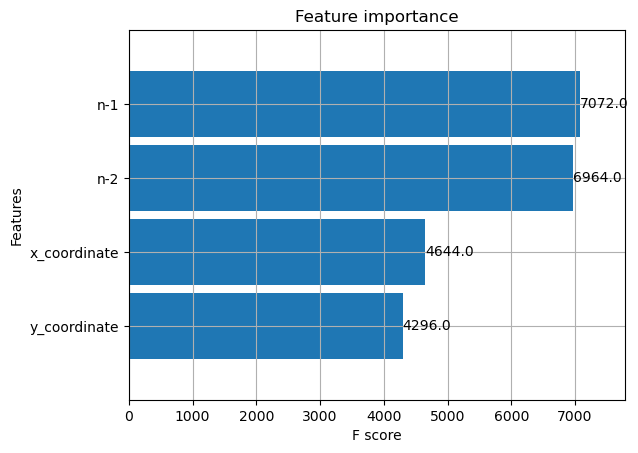

In [23]:
model.set_params(best_hyperparams)
model.fit()
model.feature_importance()

In [24]:
predicted_2019 = model.predict(2019)

In [25]:
predicted_2018 = model.predict(2018)
predicted_2018

array([9.596714 , 9.621136 , 8.764036 , ..., 1.9906238, 2.2137635,
       1.5074432], dtype=float32)

In [26]:
data.addYearDemandfromForecast(2019, predicted_2019)

In [27]:
data.df_trans

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,13.586238
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,12.912865
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,15.323978
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,18.275579
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,18.355495
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,3.291473
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,1.746053
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,2.661610
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,3.336923


In [28]:
predicted_2020 = model.predict(2020)

In [29]:
data.addYearDemandfromForecast(2020, predicted_2020)

In [30]:
data.df_trans

,demand_point_index,x_coordinate,y_coordinate,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,0.5,0.5,0.352242,0.667932,0.958593,2.911901,4.338274,6.561995,8.454417,10.595324,13.119572,13.586238,18.715380
1,1,1.5,0.5,0.325940,0.591964,0.862652,2.589068,4.196034,5.745551,8.753195,11.126995,12.020091,12.912865,15.154009
2,2,2.5,0.5,0.373752,0.591890,0.969733,2.641432,3.541772,5.469161,8.414627,10.115336,14.018254,15.323978,21.438286
3,3,3.5,0.5,0.420686,0.584055,0.906547,2.378577,3.888121,5.846089,9.083868,12.424885,15.012302,18.275579,22.851284
4,4,4.5,0.5,0.475621,0.647940,0.981544,2.665400,4.218711,6.776609,8.851107,11.731131,16.355563,18.355495,23.858601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,4091,59.5,63.5,0.171015,0.334565,0.556055,1.373291,1.837586,2.517146,3.352280,4.149888,5.426193,3.291473,8.493338
4092,4092,60.5,63.5,0.041716,0.061741,0.131291,0.386540,0.755846,0.941116,1.107797,1.309479,2.057450,1.746053,2.836246
4093,4093,61.5,63.5,0.100895,0.180352,0.296299,0.705373,1.300220,1.608609,1.822806,2.333681,3.218519,2.661610,3.381201
4094,4094,62.5,63.5,0.155353,0.290825,0.557803,1.516066,2.399426,2.719197,4.494515,6.096858,6.262574,3.336923,7.509088


In [93]:
data.df_trans.to_csv("data/forecast.csv")